In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import numpy as np
import pandas as pd

from utils.load_data import get_HGdata
from utils.plotting import plot_clusters, plot_singletrials

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform

# Clustering electrodes by temporal profiles in electrocorticography

![1cm_grid](1cm_grid.png "1 cm electrode spacing") ![4mm_grid](4mm_grid.png "4 mm spacing")

# the data
* Continuous time series data (downsampled to 1kHz)
* One dataset approx 64 x 1,400,000

![rawdata](rawdata.png)

![electrode coverage](coverage.png)

## ECOG signal

Two primary components, each carrying unique information
1. low frequency oscillations (<40Hz) 
2. broadband spectral power change (70-200Hz; aka high gamma)

HG indexes local cortical activation (neuronal firing)

## epoched HG data
data has been formatted into elecs x trials x time matrix <br>
trials locked to stimulus presentation <br>
reading it in from `.mat` file (legacy reasons)

In [3]:
#get data
filename = 'data/S15_HG_elecMTX_zscore.mat'
var_list = ['srate','data_zscore','active_elecs', 'RTs'] #vars of interest
srate, alldata, active_elecs, RTs = get_HGdata(filename, var_list)

# variables:
#    alldata = HG data matrix - elecs x trials x time
#    srate = data sampling rate
#    active_elecs = electrode indices
#    RTs = reaction times (in srate)

In [4]:
alldata.shape #elecs x trials x time

(31, 147, 4799)

## plot single trials for sample electrodes
each plot is trials x time<br>
color intensity shows HG zscored relative to prestimulus baseline<br>
vertical black line at 0 is stimulus presentation<br>
trials locked to stimulus presentation
jagged black line is reaction time<br>

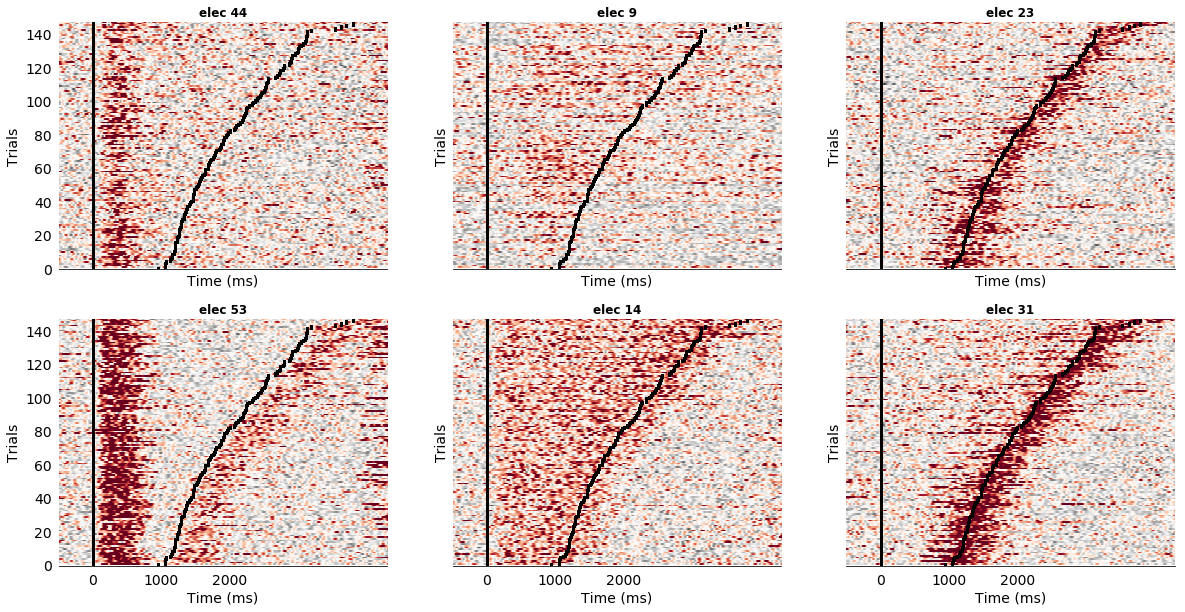

In [5]:
f, ax = plt.subplots(2, 3, sharey = True, sharex = True, figsize=(20,10))
ax = ax.flatten()

elecs = [44, 9, 23, 53, 14, 31] #some example elecs
for i, elec in enumerate(elecs):
    a = plot_singletrials(filename, [elec], fig = f, ax = ax[i], cbar = False)
    a.set_title('elec {0}'.format(elec), fontweight='bold')

# How can we group it into meaningful clusters?

# PCA with EFA
See `PCA_withEFA_R.ipynb`

# Hierarchical clustering

Calculate pairwise distances between observations (using correlation)

Perform agglomerative clustering using the distance matrix.

Group observations using *complete linkage* 

* Complete linkage calculates the distance between farthest elements in cluster

* Leads to spherical clusters where all points are reasonably close to each other


In [6]:
#get data (elecs x components) 1 dataset (subject S15 performing antonym generation task)
filename = 'data/S15_EmoGen_loadings.csv'
df = pd.read_csv(filename)

In [7]:
distance = pdist(df, 'correlation') #create distance matrix using correlation (condensed : m*(m – 1)/2)

Z = hc.linkage(distance, method = 'complete') # links objects together based on distance matrix using complete linkage
# Rows = links, Z[:,0] and Z[:,1] = linked observations. Z[:,2] = distance between them; Z[:,3] = number of leaves


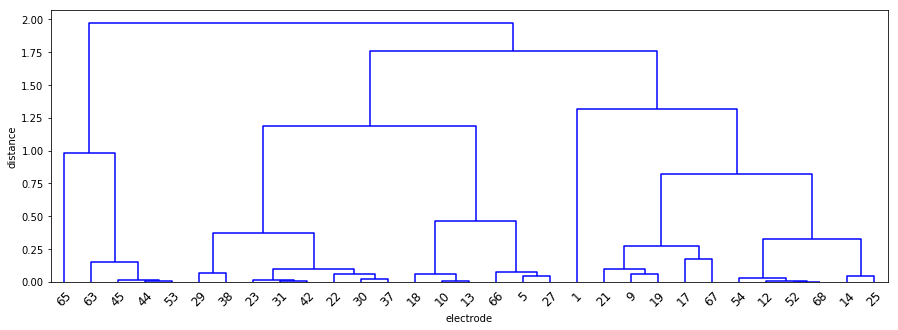

In [8]:
#plot dendrogram to see distances between elements and clusters
f, ax = plt.subplots(figsize = (15,5))
dend = hc.dendrogram(Z, labels = df.index, color_threshold=0, leaf_font_size = 12, ax = ax) 
ax.set_xlabel('electrode')
ax.set_ylabel('distance')

## Decide where to split the dendrogram

Once have dendrogram can cut wherever you want and get a different number of clusters

Inconsistency coefficient
* The normalized difference between link height and the average link height

Inconsistent links indicate a natural division in the data
* A big height relative to children suggests that objects joined at this level are farther apart from each other than their children were when they merged
* Use the median inconsistency coefficient as the `cutoff` to partition the data into electrode groups.

Cut using `distance` criterion
* Distance is the height of the link between the two clusters that contain the objects.
 * height is less than `cutoff` 


In [9]:
incon = hc.inconsistent(Z) #inconsistency
cutoff = np.median(incon[:,-1])
print cutoff
#hist(incon[:,-1], bins=np.arange(min(incon[:,-1]), max(incon[:,-1]) + .01, .01))

0.707106781187


In [10]:
cluster = hc.fcluster(Z, cutoff, criterion = 'distance')

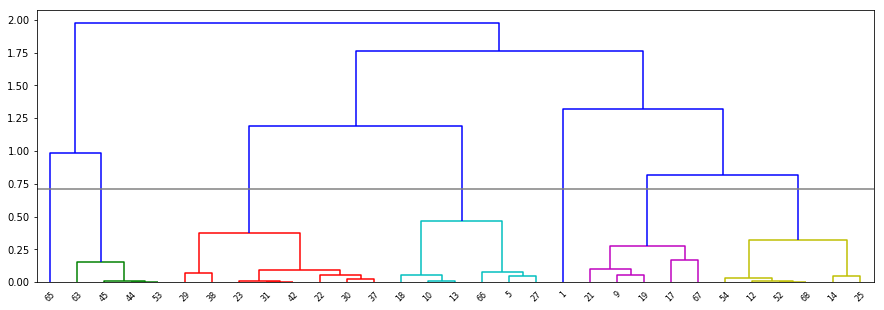

In [11]:
#replot dendrogram with colors per cluster and cutoff
f, ax = plt.subplots(figsize = (15,5))
dend = hc.dendrogram(Z, labels = df.index, color_threshold = cutoff, ax = ax)
ax.axhline(y = cutoff, color = 'gray')

In [12]:
#dataframe with cluster designation per electrode
groupidx = pd.DataFrame(cluster, index = df.index, columns = ['cluster'])
groupidx.head()

cluster
1         7
5         4
9         5
10        4
12        6

## Brain plots

In [13]:
recon_path = 'data/S15_Lateral_Left_blankelecs.png'
xycoord_path = 'data/S15_xycoords.p'
filename = 'data/S15_HG_elecMTX_percent.mat'

In [14]:
#groupidx = groupidx.drop([65, 66, 67, 68]) #not on recon.

utils/plotting.py:166: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  plot_xy_map(groupidx[['cluster']], locs = xycoords.loc[groupidx.index], ax = ax3, colors = c, szmult=1000, cmap = cmap, im_path = recon_path)


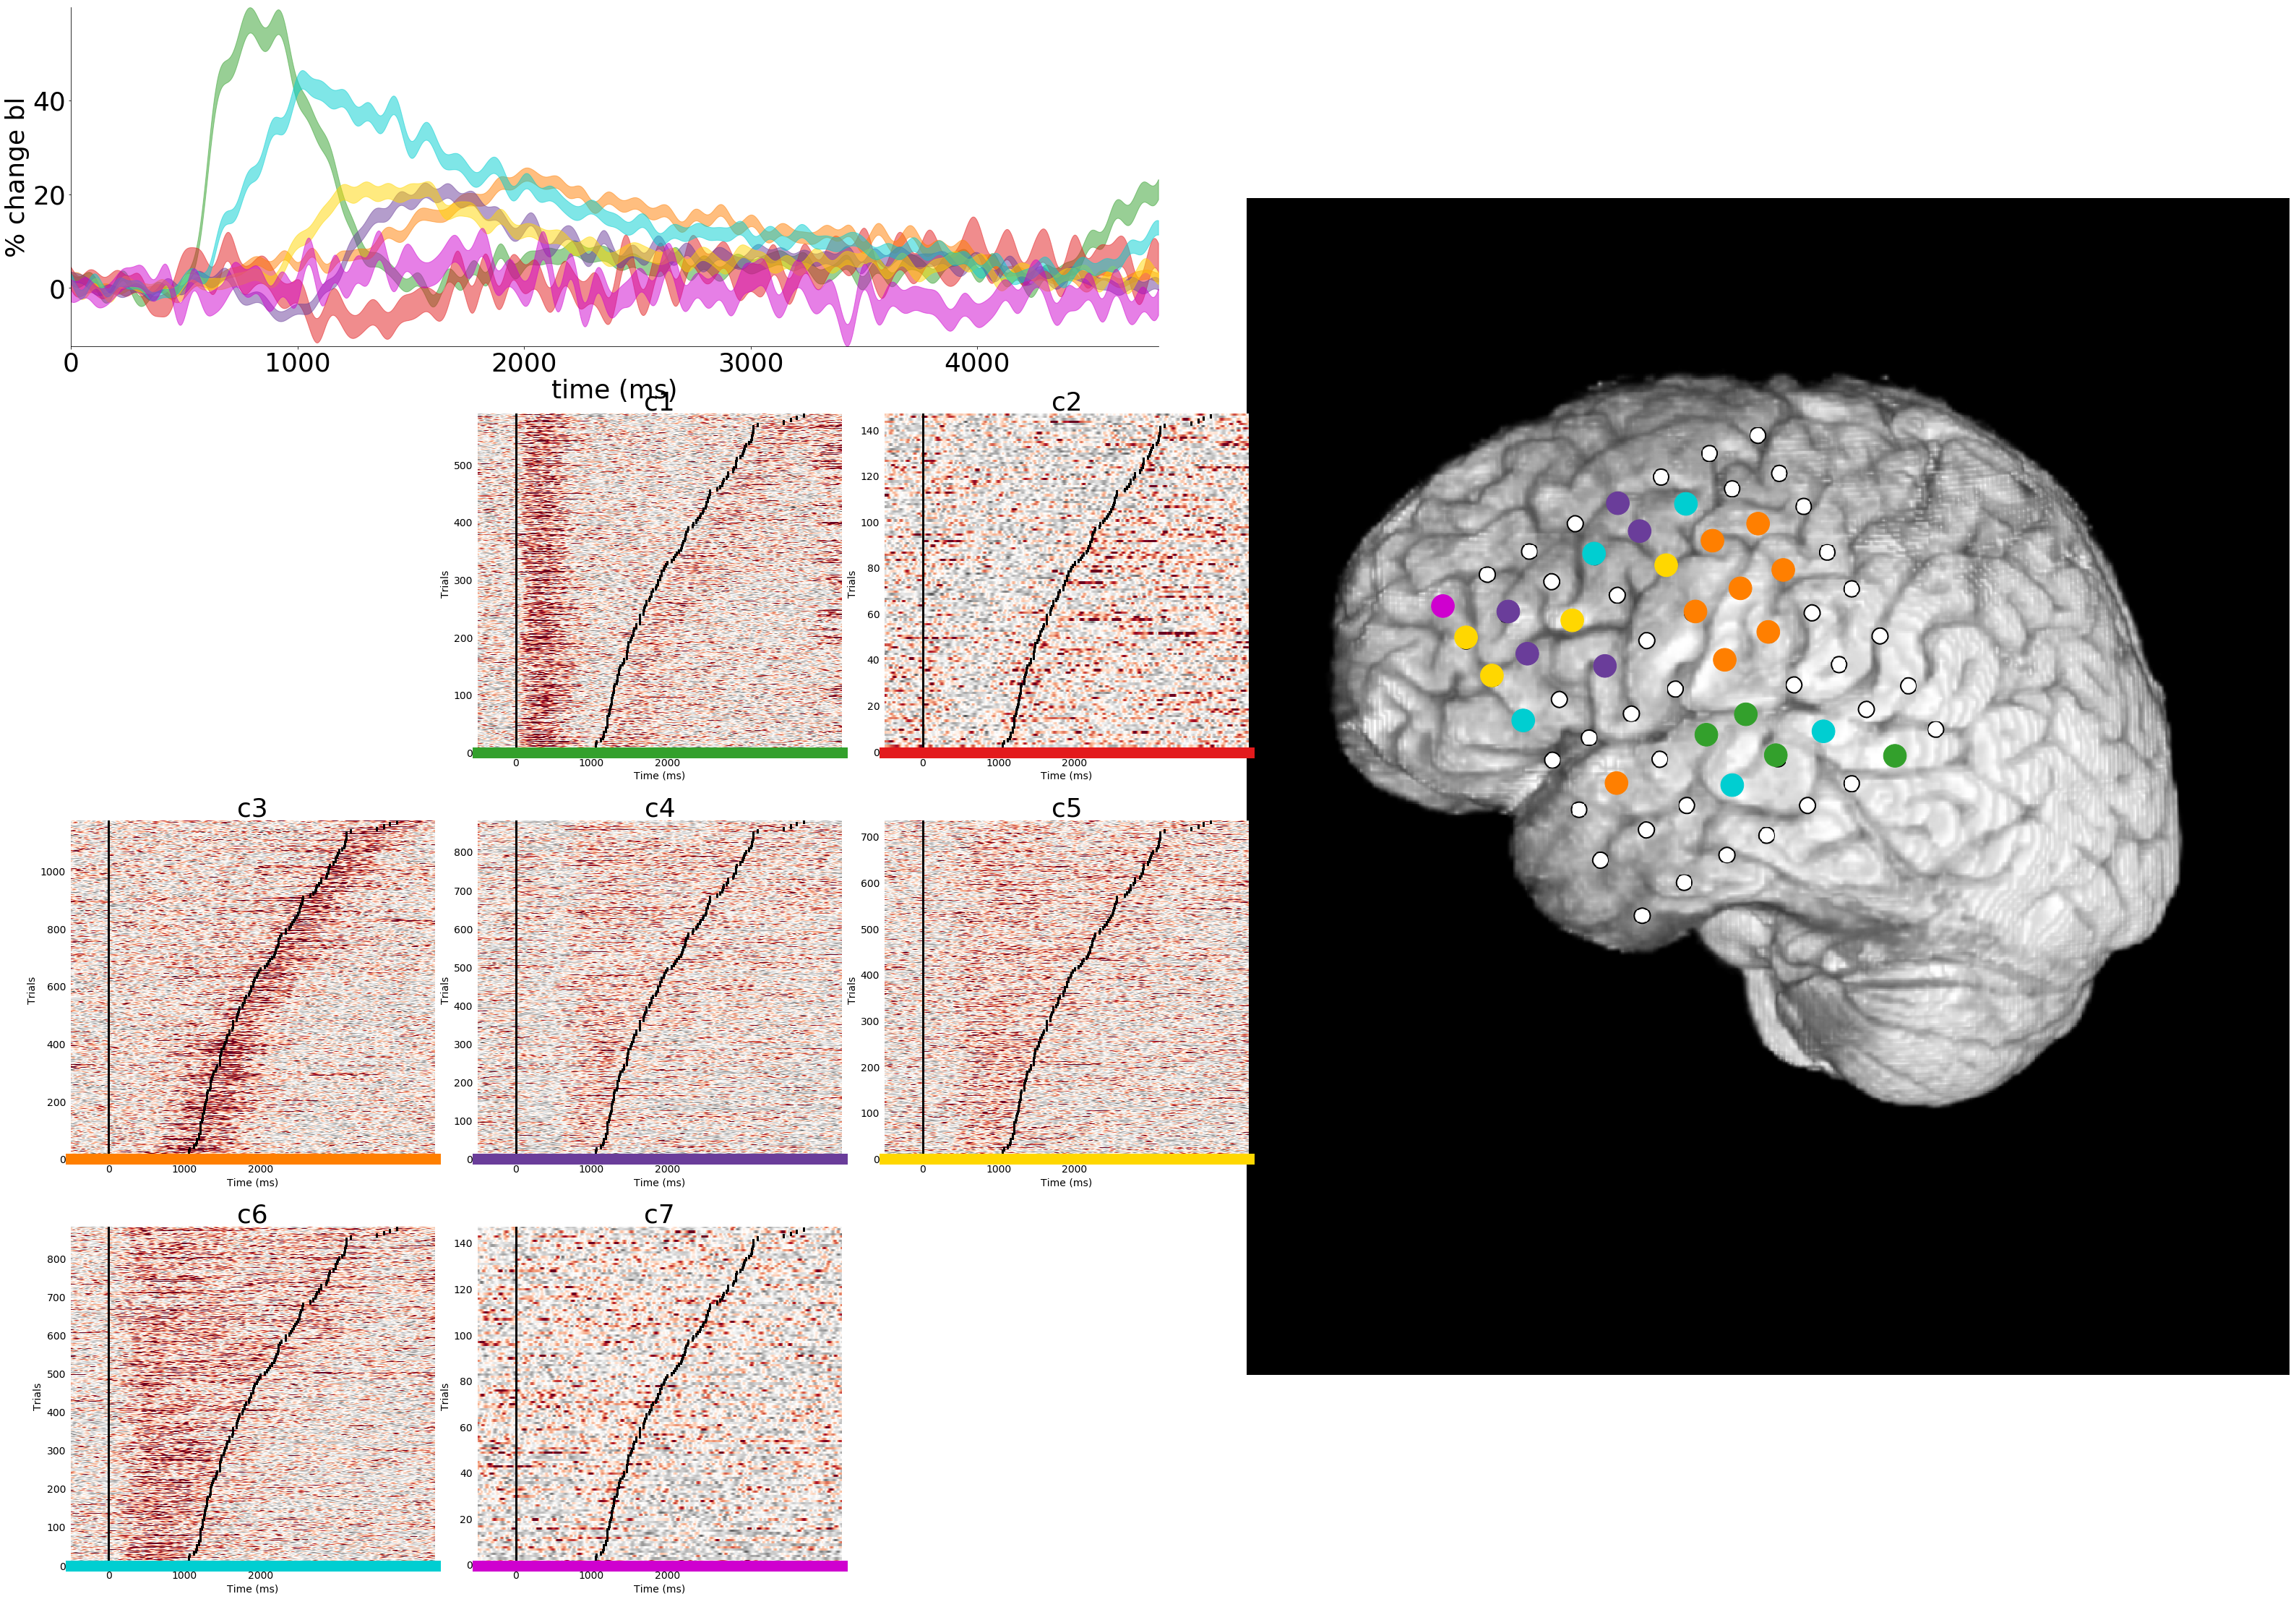

In [15]:
plot_clusters(filename, recon_path, xycoord_path, groupidx)